In [1]:
import pickle as pkl
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import soundfile as sf
import tqdm
audio_dir = './data/crowd/crowd_audio'
alignment_dir = './data/crowd/crowd_aligned'

In [2]:
crowd_data = pkl.load(open('./data/crowd/crowd_audio.pkl', 'rb'))

In [3]:
df = pd.read_csv('./data/dataset_files/crowd-source__asr_2021-11-08__final__ALL.csv')
dnndf = pd.read_csv('./data/dataset_files/DNN.csv')
crowd_df = df[df['steps.stepCategory']=='sentence']
dnncrowd = dnndf[dnndf['sample'].isin(['crowd', 'crowd_issue'])]
dnnids = list(dnncrowd['File_id'])
crowd_df = crowd_df[crowd_df['steps.participantId'].isin(dnnids)]

/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (5,50,51,52,53,54,55,56,57,58,59,60,62,63,64,65,66,67,68,69,73,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,150,151,152,153,154,169,170,171,172,173,174,335,336,338,339,340,341,342,343,344,345,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,450,451,452,453,454,455,456,457,458,459,460,461,462,463,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,579,580,581,583,584,586,587,589) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
crowd_pids = list(crowd_data.keys())

In [5]:
lens = []
for pid in tqdm.tqdm(crowd_pids):
    pid_dict = crowd_data[pid]
    steps = list(pid_dict.keys())
    # print(steps)
    # print(pid_dict['29'])
    for step in steps:
        pid_dir = os.path.join(audio_dir, pid)
        if not os.path.exists(pid_dir):
            os.makedirs(pid_dir, exist_ok=True)
        audiofilename = os.path.join(audio_dir, pid, pid + '-' + str(step) + '.wav')
        transcript_filename = os.path.join(audio_dir, pid, pid + '-' + str(step) + '.lab')
        stepdata = pid_dict[step]
        audio = stepdata['audio']
        lens.append(len(audio))
        transcript = stepdata['transcript']
        sf.write(audiofilename, audio, 16000)
        f = open(transcript_filename, 'w')
        f.write(transcript)
        f.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:05<00:00, 45.39it/s]


(array([  1.,   0.,   3.,  64., 206., 369., 188., 157.,  97.,  43.,   7.,
          7.,   6.,   3.,   1.,   0.,   1.,   0.,   0.,   2.]),
 array([ 1.024     ,  1.77493437,  2.52586875,  3.27680312,  4.0277375 ,
         4.77867187,  5.52960625,  6.28054062,  7.031475  ,  7.78240937,
         8.53334375,  9.28427813, 10.0352125 , 10.78614688, 11.53708125,
        12.28801562, 13.03895   , 13.78988437, 14.54081875, 15.29175312,
        16.0426875 ]),
 <BarContainer object of 20 artists>)

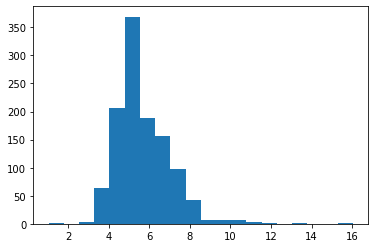

In [13]:
plt.hist(np.array(lens)/16000, bins=20)

In [14]:
from gop_helper_fns import *

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/prad/anaconda3/envs/alignment/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [15]:
import time
session_artp_validation_dict = {}
crowd_artp_dictpath = './crowd_artps.pkl'

for pid in tqdm.tqdm(crowd_pids):
    pid_dict = crowd_data[pid]
    steps = list(pid_dict.keys())
    session_artp_validation_dict[pid] = {}
    for step in steps:
        audio_filename = os.path.join(audio_dir, pid, pid + '-' + str(step) + '.wav')
        alignment_file = os.path.join(alignment_dir, 'crowd-audio-' + pid + '-' + str(step) + '.TextGrid')
        stepdata = pid_dict[step]
        transcript = stepdata['transcript']
        try:
            __, step_artp = calculate_GOP_e2e(audio=audio_filename, transcript=transcript, textgrid_alignment=alignment_file)
            session_artp_validation_dict[pid][step] = step_artp
        except:
            session_artp_validation_dict[pid][step] = np.nan
        # print(pid, step, step_artp)
        time.sleep(.01)
pkl.dump(session_artp_validation_dict, open(crowd_artp_dictpath, 'wb'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [03:14<00:00,  1.19it/s]


In [60]:
def add(a, b, **kwargs):
    sumval = a+b
    # for arg in kwargs.values():
    print(len(kwargs))
    return sumval
print(add(2, 3, c=5))
print(add(2, 3))

1
5
0
5


In [ ]:
participantids = dnncrowd['File_id']
df_partids = np.array(list(crowd_df['session.participantId']))
artps_array = np.zeros([len(df_partids), 5])
steps = stepid_to_transcript.keys()
results_dict = './crowd_validation_artps_w2v_fixed.pkl'

if not os.path.exists(results_dict):
    session_artp_validation_dict = {}
    for ii, pid in tqdm.tqdm(enumerate(participantids)):
        session_artp_validation_dict[pid] = {}
        inds = np.argwhere(df_partids==pid).ravel()
        _sessid = crowd_df.iloc[inds]['session.sessionId'].iloc[0]
        # _sessidz = 
        for jj, _prompt_substr in enumerate(prompt_substrings)
